In [1]:
import catboost as cat
from sklearn import datasets
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import log_loss, make_scorer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator
import copy
from scipy.stats import uniform, loguniform, randint 
from tqdm import tqdm # for some reason tqdm.notebook is not working....

In [2]:
SEED = 42

# should still check when to stratify
def preprocess_dataset(dataset, categorical_encoding='label', categorical_type='category'):
    dataset = copy.deepcopy(dataset) # to preserve mutable object
    # if there is no default test data
    if dataset['test_data'] is None:
        X_train, X_test, y_train, y_test = train_test_split(dataset['data'], dataset['target'], test_size=0.25,
                                                            random_state=SEED)
        dataset['data'] = X_train
        dataset['target'] = y_train
        dataset['test_data'] = X_test
        dataset['test_target'] = y_test

    # label encoding for classification task, float for regression
    if dataset['task'] == 'classification':
        label_encoder = LabelEncoder()
        dataset['label_encoder'] = label_encoder
        dataset['target_processed'] = label_encoder.fit_transform(dataset['target'])
        dataset['test_target_processed'] = label_encoder.transform(dataset['test_target'])
    else:
        dataset['label_encoder'] = None
        dataset['target_processed'] = dataset['target'].astype('float')
        dataset['test_target_processed'] = dataset['test_target'].astype('float')
    # encodes categorical data
    if categorical_encoding == 'label':
    # order of columns is preserved
        encoder = OrdinalEncoder(encoded_missing_value=-1)
        dataset['encoder'] = encoder
        dataset['data'].iloc[:,dataset['cat_features']] = encoder.fit_transform(
            dataset['data'].iloc[:,dataset['cat_features']])
        dataset['test_data'].iloc[:,dataset['cat_features']] = encoder.transform(
            dataset['test_data'].iloc[:,dataset['cat_features']])
    if categorical_encoding == 'one_hot':
    # in the case of the one hot encoding we will first have the continuous columns and after the categorical
    # (one hot encoded)
        encoder = OneHotEncoder(drop='if_binary',sparse=False) # Nan is treated as another category (extra column)
        dataset['encoder'] = encoder
        dataset['data'] = (dataset['data'].iloc[:,dataset['cont_features']]
                           .join(pd.DataFrame(encoder.fit_transform(dataset['data'].iloc[:,dataset['cat_features']]))))
        dataset['test_data'] = (dataset['test_data'].iloc[:,dataset['cont_features']]
                                .join(pd.DataFrame(encoder.transform(dataset['test_data'].
                                                                     iloc[:,dataset['cat_features']]))))
        dataset['cont_features'] = [i for i in range(len(dataset['cont_features']))]
        dataset['cat_features'] = [i for i in range(len(dataset['cont_features']),dataset['data'].shape[1])]
    if categorical_encoding == 'pandas':
        dataset['data'][dataset['data'].columns[dataset['cat_features']]] = (
            dataset['data'][dataset['data'].columns[dataset['cat_features']]].astype('str'))    
        dataset['test_data'][dataset['data'].columns[dataset['cat_features']]] = (
            dataset['test_data'][dataset['data'].columns[dataset['cat_features']]].astype('str'))
    # continuous features as float and categorical features as category
    # obs: for some reason it does not work with iloc[:,dataset['cat_features']], we use 
    # .columns[dataset['cat_features']] instead...
    dataset['data'][dataset['data'].columns[dataset['cat_features']]] = (
        dataset['data'][dataset['data'].columns[dataset['cat_features']]].astype(categorical_type))
    dataset['test_data'][dataset['data'].columns[dataset['cat_features']]] = (
        dataset['test_data'][dataset['data'].columns[dataset['cat_features']]].astype(categorical_type))
    dataset['data'][dataset['data'].columns[dataset['cont_features']]] = (
        dataset['data'][dataset['data'].columns[dataset['cont_features']]].astype('float'))
    dataset['test_data'][dataset['data'].columns[dataset['cont_features']]] = (
        dataset['test_data'][dataset['data'].columns[dataset['cont_features']]].astype('float'))
    return dataset

def run_cat(dataset, n_jobs=None):
    early_stopping_rounds = None
    parameters = {
        'random_seed':SEED,
        'thread_count':n_jobs,
        'early_stopping_rounds':early_stopping_rounds,
        'verbose':False,
        'cat_features':dataset['cat_features'] if dataset['cat_features'] else None,
    }
    if dataset['task'] == 'classification':
        n_classes = len(np.unique(dataset['target_processed']))
        if n_classes == 2:
            parameters['loss_function'] = 'Logloss'
            parameters['eval_metric'] = 'Logloss'
            parameters['custom_metric'] = 'AUC'
        elif n_classes > 2:
            parameters['loss_function'] = 'MultiClass'
            parameters['eval_metric'] = 'MultiClass'
            parameters['custom_metric'] = 'AUC'
            parameters['classes_count'] = n_classes
        else:
            error = True
        model = cat.CatBoostClassifier(**parameters)
    if dataset['task'] == 'regression':
        parameters['loss_function'] = 'RMSE'
        parameters['eval_metric'] = 'RMSE'
        model = cat.CatBoostRegressor(**parameters) 
    X_train = dataset['data']
    y_train = dataset['target_processed']
    X_test = dataset['test_data']
    y_test = dataset['test_target_processed']
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=SEED)
    eval_set = [(X_train, y_train), (X_test, y_test), (X_val, y_val)] 
    model.fit(X_train, y_train, eval_set=eval_set)
    return model

def run_cat_hpo(dataset, n_jobs=None):
    hp_space = {
        'learning_rate':loguniform(a=1e-6, b=1), # interval = [a, b] 
        # EVEN THOUGH THEY RECOMMEND 1e-7 we found an error when the learning rate is too small
        'random_strength':randint(low=1, high=(20 + 1)), # interval = [low, high[
        'one_hot_max_size':randint(low=1, high=(25 + 1)),
        'l2_leaf_reg':loguniform(a=1, b=10),
        'bagging_temperature':uniform(loc=0, scale=1), # interval = [loc, loc + scale]
        'leaf_estimation_iterations':randint(low=1, high=(10 + 1)),
#         'iterations':randint(low=1, high=(4000 + 1)),
    }
    early_stopping_rounds = None
    parameters = {
        'random_seed':SEED,
        'thread_count':n_jobs,
        'early_stopping_rounds':early_stopping_rounds,
        'verbose':False,
        'cat_features':dataset['cat_features'] if dataset['cat_features'] else None,
    }
    if dataset['task'] == 'classification':
        scoring = 'neg_log_loss' # LGBM uses float64, so no need to define custom scoring
        n_classes = len(np.unique(dataset['target_processed']))
        if n_classes == 2:
            parameters['loss_function'] = 'Logloss'
            parameters['eval_metric'] = 'Logloss'
            parameters['custom_metric'] = 'AUC'
        elif n_classes > 2:
            parameters['loss_function'] = 'MultiClass'
            parameters['eval_metric'] = 'MultiClass'
            parameters['custom_metric'] = 'AUC'
            parameters['classes_count'] = n_classes
        else:
            error = True
        model = cat.CatBoostClassifier(**parameters)
    if dataset['task'] == 'regression':
        scoring = 'neg_root_mean_squared_error'
        parameters['loss_function'] = 'RMSE'
        parameters['eval_metric'] = 'RMSE'
        model = cat.CatBoostRegressor(**parameters) 
    X_train = dataset['data']
    y_train = dataset['target_processed']
    X_test = dataset['test_data']
    y_test = dataset['test_target_processed']
    hpo = RandomizedSearchCV(model, hp_space, n_iter=100, scoring=scoring, random_state=SEED, n_jobs=4,
                             refit=False)
    hpo.fit(X_train, y_train)
    hpo.best_estimator_ = hpo.estimator.set_params(**hpo.best_params_)
    eval_set = [(X_train, y_train), (X_test, y_test)]
    hpo.best_estimator_.fit(X_train, y_train, eval_set=eval_set, verbose=False)
    return hpo

def plot_learning_curve_lgb(model, name):
    result = model.evals_result_
    for metric in result['validation_0']:
        fig, ax = plt.subplots()
        ax.plot(result['validation_0'][metric], label='train')
        ax.plot(result['validation_1'][metric], label='test')
        ax.legend()
        ax.set_xlabel('iteration')
        ax.set_ylabel(metric)
        ax.set_title(name)

In [3]:
# iris
iris = datasets.load_iris(as_frame=True)
iris.update({
    'name':'iris',
    'task':'classification',
    'cat_features':[],
    'cont_features':[0, 1, 2, 3],
#     'data': already specified when loading the dataset from scikit-learn
#     'target': already specified when loading the dataset from scikit-learn
    'test_data':None,
    'test_target':None
})
# diabetes
diabetes = datasets.load_diabetes(as_frame=True)
diabetes.update({
    'name':'diabetes',
    'task':'regression',
    'cat_features':[],
    'cont_features':[i for i in range(10)],
#     'data': already specified when loading the dataset from scikit-learn
#     'target': already specified when loading the dataset from scikit-learn
    'test_data':None,
    'test_target':None
})
# wine
wine = datasets.load_wine(as_frame=True)
wine.update({
    'name':'wine',
    'task':'classification',
    'cat_features':[],
    'cont_features':[i for i in range(13)],
#     'data': already specified when loading the dataset from scikit-learn
#     'target': already specified when loading the dataset from scikit-learn
    'test_data':None,
    'test_target':None
})
# breast cancer
breast_cancer = datasets.load_breast_cancer(as_frame=True)
breast_cancer.update({
    'name':'breast_cancer',
    'task':'classification',
    'cat_features':[],
    'cont_features':[i for i in range(30)],
#     'data': already specified when loading the dataset from scikit-learn
#     'target': already specified when loading the dataset from scikit-learn
    'test_data':None,
    'test_target':None
})
# # covtype
# it is a bit to slow just to test and see if the algos are working
# covtype = datasets.fetch_covtype(as_frame=True)
# covtype.update({
#     'name':'covtype',
#     'task':'classification',
#     'cat_features':[i for i in range(10,54)],
#     'cont_features':[i for i in range(10)],
# #     'data': already specified when loading the dataset from scikit-learn
# #     'target': already specified when loading the dataset from scikit-learn
#     'test_data':None,
#     'test_target':None
# })
# kddcup99_sa
# obs we have a problem in the data, the classes b'nmap.', b'pod.', b'portsweep.' only have one single example,
# so we filter it - > Actually we will not use it for now, because each time we fetch the dataset we select a random
# sample from the total dataset and different cases of infrequent classes must be handle....to do one day
# kddcup99_sa = datasets.fetch_kddcup99(subset='SA', as_frame=True, random_state=SEED)
# kddcup99_sa.update({
#     'name':'fetch_kddcup99_sa',
#     'task':'classification',
#     'cat_features':[1, 2, 3, 6, 11, 20, 21],
#     'cont_features':[0, 4, 5] + [i for i in range(7, 11)] + [i for i in range(12, 20)] + [i for i in range(22, 40)],
#     'data': kddcup99_sa['data'].loc[~kddcup99_sa['target'].isin([b'nmap.', b'pod.', b'portsweep.'])],
#     'target': kddcup99_sa['target'].loc[~kddcup99_sa['target'].isin([b'nmap.', b'pod.', b'portsweep.'])],
#     'test_data':None,
#     'test_target':None
# })
# # kddcup99_sf
# kddcup99_sf = datasets.fetch_kddcup99(subset='SF', as_frame=True)
# kddcup99_sf.update({
#     'name':'fetch_kddcup99_sf',
#     'task':'classification',
#     'cat_features':[1],
#     'cont_features':[0, 2, 3],
# #     'data': already specified when loading the dataset from scikit-learn
# #     'target': already specified when loading the dataset from scikit-learn
#     'test_data':None,
#     'test_target':None
# })
# california_housing 
california_housing = datasets.fetch_california_housing(as_frame=True)
california_housing.update({
    'name':'california_housing',
    'task':'regression',
    'cat_features':[],
    'cont_features':[i for i in range(7)],
#     'data': already specified when loading the dataset from scikit-learn
#     'target': already specified when loading the dataset from scikit-learn
    'test_data':None,
    'test_target':None
})

# download dataset from uci
url_data = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
url_test = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test'
nan_token = ' ?'
adult = {
    'name':'adult',
    'task':'classification',
    'cat_features':[1, 3, 5, 6, 7, 8, 9, 13],
    'cont_features':[0, 2, 4, 10, 11, 12],
    'data':pd.read_csv(url_data, header=None, na_values=nan_token).iloc[:,0:-1],
    'target':pd.read_csv(url_data, header=None, na_values=nan_token).iloc[:,-1],
    'test_data':pd.read_csv(url_test, header=None, skiprows=1, na_values=nan_token).iloc[:,0:-1],
    'test_target':pd.read_csv(url_test, header=None, skiprows=1, na_values=nan_token).iloc[:,-1].str[:-1]
}

all_datasets = [iris, diabetes, wine, breast_cancer, california_housing, adult]

In [4]:
preprocessed_datasets = [preprocess_dataset(dataset, 'pandas', 'category') for dataset in all_datasets]
# for catboost categorical features must be int or str (without any encoding) and NaN values must be one of the ones
# in here https://catboost.ai/en/docs/concepts/algorithm-missing-values-processing...which means that if we are working
# with pandas and the 'category' dtype, we must first convert the categories to str and after to 'category'

In [5]:
n_jobs=10
models_no_hpo = [run_cat(dataset_preprocessed, n_jobs) for dataset_preprocessed in preprocessed_datasets]

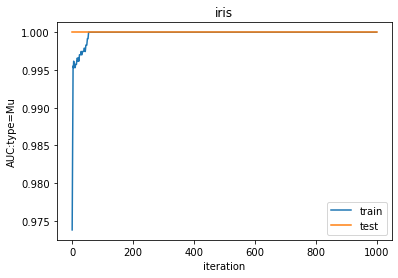

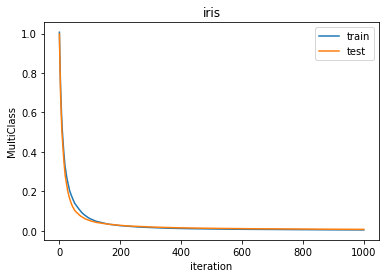

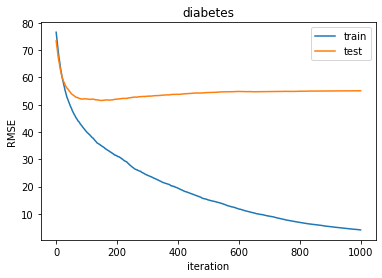

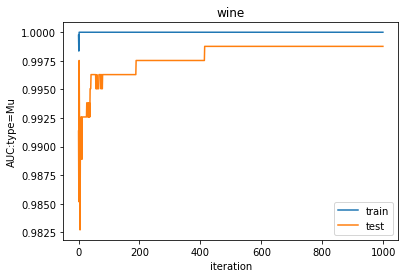

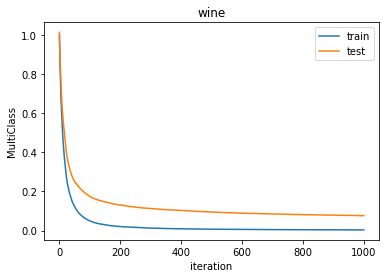

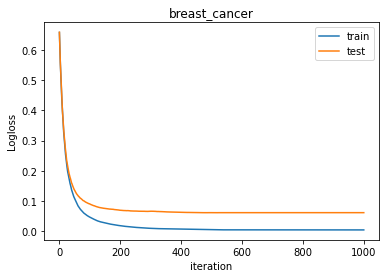

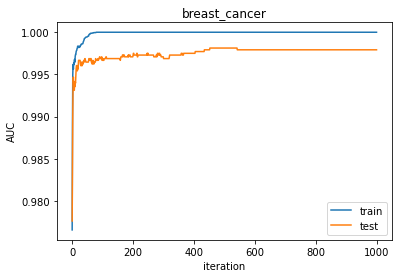

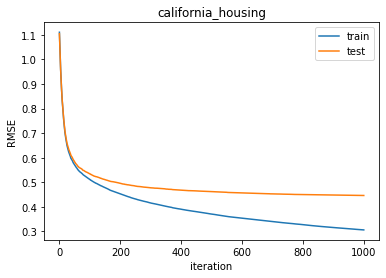

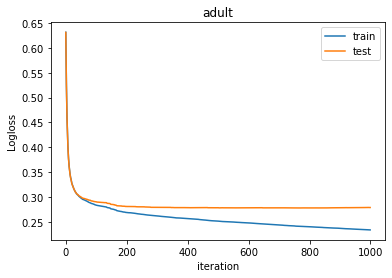

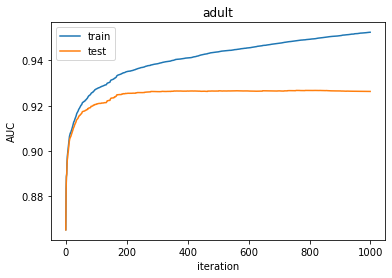

In [6]:
for model, dataset in zip(models_no_hpo, preprocessed_datasets):
    plot_learning_curve_lgb(model, dataset['name'])

In [7]:
n_jobs = 8
models_hpo = [run_cat_hpo(dataset_preprocessed, n_jobs=n_jobs) for dataset_preprocessed in preprocessed_datasets]

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [8]:
results_no_hpo = [model.evals_result_['validation_1'][ # validation_1 = test
    next(iter(model.evals_result_['validation_1']))][-1] for model in models_no_hpo] # -1 last iterarion

In [9]:
results_hpo = [model.best_estimator_.evals_result_['validation_1'][ # validation_1 = test
    next(iter(model.best_estimator_.evals_result_['validation_1']))][-1] for model in models_hpo] # -1 last iterarion

In [10]:
names = [dataset['name'] for dataset in all_datasets]
pd.DataFrame([results_no_hpo, results_hpo], columns=names, index = ['no_hpo', 'hpo'])

,iris,diabetes,wine,breast_cancer,california_housing,adult
no_hpo,1.0,55.127641,0.998765,0.060983,0.446379,0.278986
hpo,1.0,50.476137,1.000000,0.059818,0.440485,0.275240


In [11]:
model = models_hpo[0]

In [12]:
model.best_estimator_.evals_result_['validation_1'].keys()

dict_keys(['AUC:type=Mu', 'MultiClass'])

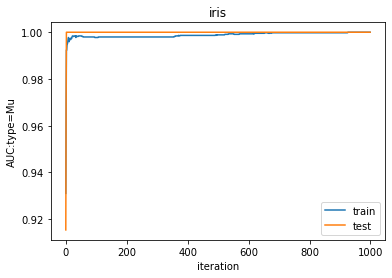

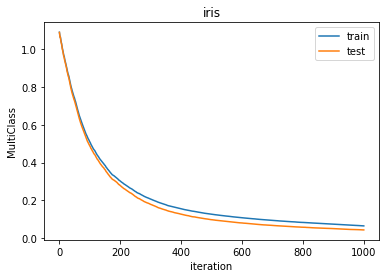

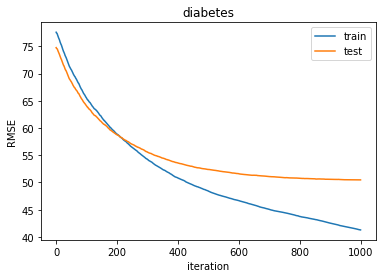

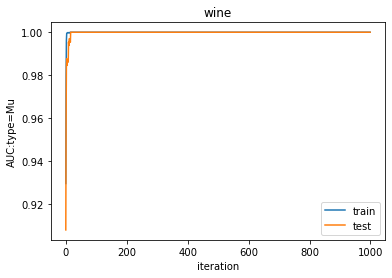

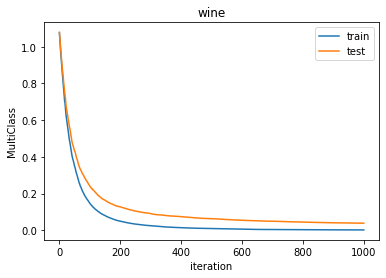

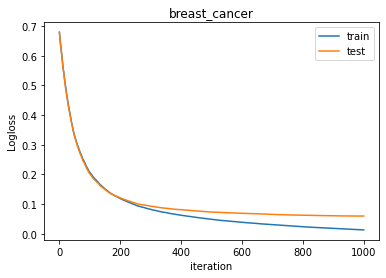

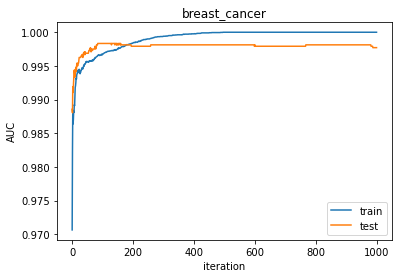

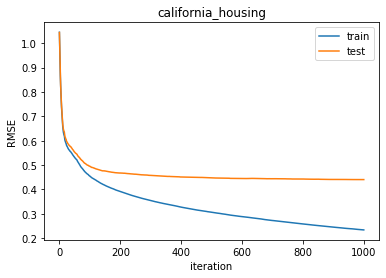

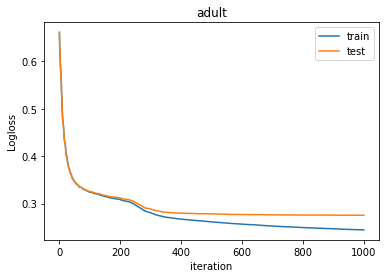

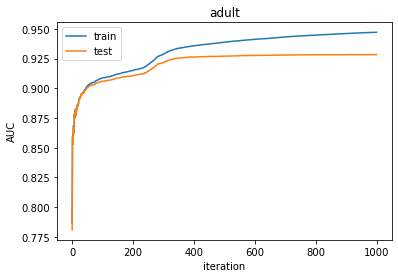

In [13]:
for model, dataset in zip(models_hpo, preprocessed_datasets):
    plot_learning_curve_lgb(model.best_estimator_, dataset['name'])